# 2D Full Waveform Inversion (FWI) on a single Azure VM using GPU or CPU

FWI is a seismic velocity model building tool that uses the entire content of seismic traces to invert for high-resolution, high-fidelity velocity models of the subsurface. It iteratively refines the velocity model by reducing the difference between the modeled data and the recorded data. In this jupyter notebook demo, we show an end-to-end example of 2D acoustic isotropic FWI using the synthetic [Marmousi](https://library.seg.org/doi/10.1190/1.1437051) velocity model. This demo is based on [Devito](https://github.com/devitocodes/devito) and inherited/modified from the [2D FWI tutorial](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/03_fwi.ipynb). Following this demo requires some basic knowledge of Azure, Linux, Python and Geophysics. 

The main purpose of this demo is to show 2D FWI can run smoothly on Azure, with flexible adaptability to various GPU/CPU hardware architectures. Although most FWI for real data processing is 3D, this 2D FWI example allows a user to repeat the end-to-end FWI workflow using a limited computational resource. We suggest using one of the [NC](https://docs.microsoft.com/en-us/azure/virtual-machines/nc-series), [NCv2](https://docs.microsoft.com/en-us/azure/virtual-machines/ncv2-series?toc=/azure/virtual-machines/linux/toc.json&bc=/azure/virtual-machines/linux/breadcrumb/toc.json), [NCv3](https://docs.microsoft.com/en-us/azure/virtual-machines/ncv3-series?toc=/azure/virtual-machines/linux/toc.json&bc=/azure/virtual-machines/linux/breadcrumb/toc.json), [ND](https://docs.microsoft.com/en-us/azure/virtual-machines/nd-series?toc=/azure/virtual-machines/linux/toc.json&bc=/azure/virtual-machines/linux/breadcrumb/toc.json), [NV](https://docs.microsoft.com/en-us/azure/virtual-machines/nv-series?toc=/azure/virtual-machines/linux/toc.json&bc=/azure/virtual-machines/linux/breadcrumb/toc.json) GPU VMs on Azure for this notebook. At the same time, try switching to different GPU/CPU architectures to feel the easy transition. In this notebook, we also show that 2D FWI can be done in Python with high-level abstraction using Devito (Code generation framework for automated finite difference computation). This would allow a geophysist to focus on the geophysical domain through efficient programming using Devito, where the ultimate goal is to automate the code optimiazation for high-end seismic imaging tasks. 

This notebook is designed for running on a SINGLE [Virtual Machine](https://docs.microsoft.com/en-us/azure/virtual-machines/linux/) (VM) (please keep in mind limited memory of some VM could cause this demo to fail). After setting up the environment in section (1) with the PGI OpenACC compiler installed, a user can determine whether to use GPU or CPU for running this notebook by an easy switch explained in section (2). But if you plan to use CPU only, then there is no need to install the PGI OpenACC compiler. Depending on the number of GPUs or vCPUs on the VM, here is a list of choices for running this 2D FWI example on one VM.
<br> (a) using one GPU
<br> (b) using multi-GPUs with MPI (requires turning this notebook into a python script)
<br> (c) using one vCPU
<br> (d) using multi-vCPUs with OpenMP

It is very convenient for a user to switch among (a), (b), (c) and (d), without the need to modify any code in this notebook (the only thing to worry is a few environment variables). The same code/notebook adapts to Nvidia Tesla K80, M60, P40, P100, V100 GPUs, Intel Haswell, Broadwell CPUs, and more. Switching between different GPU/CPU hardware architectures is very smooth - there is no need to re-build the environment/PGI OpenACC compiler nor to adjust the Devito code. When you switch between GPU and CPU, all you need to do is updating 3 environment variables (section (2)). Switching between different GPUs is even easier (same for CPUs). For example, when you resize Nvidia K80 GPU to V100 GPU or vice versa, everything should work just fine (no need to change anything) - Devito will generate hardware optimized code since it is also a compiler.

As pointed out by (b), Devito GPU code has a MPI feature (= Domain Decomposition in this context). When an Azure VM has multiple GPUs (for example, 4 GPUs), the 2D FWI example in this notebook can also be executed with MPI. The only requirement is to turn this notebook into a python script, e.g., "fwi.py". Then run the command `DEVITO_MPI=1 mpirun -n 4 python3 fwi.py`, where "-n 4" defines the number of GPUs for MPI.



The notebook contains 7 sections:
<br> (1) Setup Devito environment on an Azure VM, and download this notebook
<br> (2) Choose (a), (b), (c) or (d) from the GPU/CPU choices (as listed above) by setting Devito environment variables
<br> (3) Load the 2D Marmousi velocity model (as the true model for FWI), and smooth it (as the initial velocity model for FWI)
<br> (4) Set up the acquisition geometry
<br> (5) Forward model true shot records with the true velocity model
<br> (6) Run 2D FWI with the modeled true shot records and the initial velocity model
<br> (7) View the 2D FWI result

## (1) Setup the Devito environment on an Azure VM

### Create an Azure VM, Install Cuda, Install OpenACC compiler, Install Devito, etc.
To set up the Devito environment on an Azure bare VM (Ubuntu Server 18.04 LTS), follow the detailed [instruction](https://github.com/devitocodes/devito/wiki/Using-Devito-on-GPUs-with-PGI-OpenACC) in the first wiki entry which is modified from the instruciton of [Using Devito on GPUs with PGI OpenACC](https://github.com/devitocodes/devito/wiki/Using-Devito-on-GPUs-with-PGI-OpenACC) at [Devito wiki](https://github.com/devitocodes/devito/wiki). Remember with PGI compiler installation we will use "python3" without a conda environment. Also remember to add Cuda and PGI compiler paths as shown in the last section of the second wiki entry.

## (2) Choose (a), (b), (c) or (d) from the GPU/CPU choices (as listed above) by setting Devito environment variables

Several Devito environment variables are used to determine configurations for using GPU/CPU. They can be set in the shell or python notebook/script, as explained in the second wiki entry. For this demo you can make a choice by simply running the first notebook cell. More info can be found from [Devito FAQ](https://github.com/devitocodes/devito/wiki/FAQ). This section (2) is the only section where a user needs to make a choice/change.

In [1]:
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning this notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

#(c) using one vCPU
#configuration['platform'] = 'cpu64'     # This is default so no need to run it
#configuration['compiler'] = 'ccustom'   # This is default so no need to run it
#configuration['language'] = 'C'         # This is default so no need to run it

#(d) using multi-vCPUs with OpenMP
#configuration['platform'] = 'cpu64'
#configuration['compiler'] = 'ccustom'
#configuration['language'] = 'openmp'

Now at this point after section (2), you don't need to change any code below for 2D FWI to run on various GPU/CPU architectures.

## (3) Load the 2D Marmousi velocity model (as the true model for FWI), and smooth it (as the initial velocity model for FWI)

### Import modules

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
#%matplotlib inline

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

from devito import configuration
configuration['log-level'] = 'WARNING'

### Load Marmousi velocity model
The 2D Marmousi velocity (Vp) model is already hosted at [devitocodes/data](https://github.com/devitocodes/data) and can be downloaded from this [link](https://github.com/devitocodes/data/blob/master/Simple2D/vp_marmousi_bi). Save the file 'vp_marmousi_bi' to the location of this notebook, otherwise you have to include the path of 'vp_marmousi_bi' for "np.fromfile" to work. In a VM, Firefox or wget can be used to download the file.

We cut the Vp model size from (1601,401) to size (1001,401) to save the computational cost. Then we smooth the original/true model Vp (kept in "model") and save the smoothed model in "model0" as an initial velocity model for FWI. We also set the Vp model spacing dx=dz=10m, origin x0=z0=0, and padding boundary nbl=20. The plot shows true & smooth Vp models, and their difference.

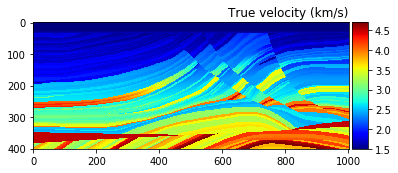

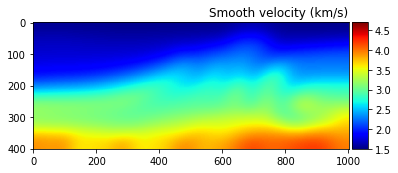

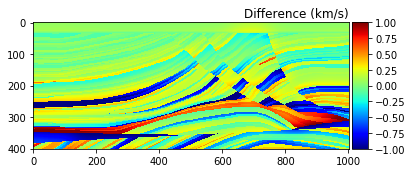

In [3]:
#Load 2D Marmousi velocity model, update the path of 'vp_marmousi_bi' as needed
v = np.fromfile('vp_marmousi_bi', dtype='float32', sep="")

#Velocity model dimension
shape = (1601, 401)
spacing = (10., 10.)
origin = (0., 0.)
nbl = 20
v = v.reshape(shape)

#Cut velocity model size from (1601,401) to (1001,401)
v = v[300:-300, :]

#Gaussian smoothing of the true velocity model
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

#True Vp model
model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
              shape=v.shape, origin=origin, spacing=spacing)

#Smooth/Initial Vp model
model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
               shape=v.shape, origin=origin, spacing=spacing)

#Plot true & smooth Vp models, and their difference
from examples.seismic import plot_image
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Smooth velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Difference (km/s)', loc='right')
plot_image(v_sm-v, vmin=-1.0, vmax=1.0, cmap="jet")

## (4) Set up the acquisition geometry 
We use 11 sources and 401 receivers that spread evenly across the whole horizontal dimension of the Vp model, with a depth of 20m. In the plot below, the top figure shows the acquisition geometry (red dot=source, green dot=receiver), overlaid with the True Vp model. The bottom figure shows the Ricker source wavelet used for this demo.

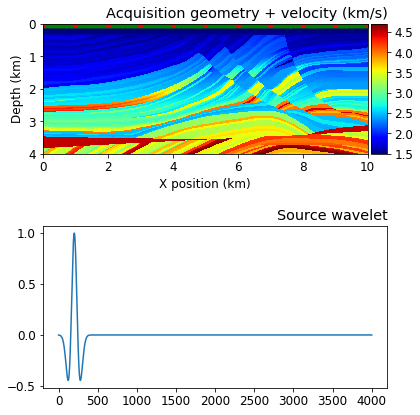

In [4]:
#set source number = 11, and receiver number = 401
nsrc=11; nrcv=401;

#set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nsrc)
src_loc[:, 1] = 20.

#set 401 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 20.

t0 = 0.     # Shot records starts at 0.0
tn = 4000.  # Shot records last 4.0 second (4000 ms)
f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

# Plot acquisition geometry overlaid with true Vp, and source wavelet
from plotting import plot_velocity
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.subplot(2,1,1); plot_velocity(model, source=src_loc, receiver=rcv_loc); 
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plt.subplot(2,1,2); plt.plot(geom_all.src.time_values, geom_all.src.data[:, 0])
plt.title('Source wavelet', loc='right')
plt.tight_layout(); plt.show()

## (5) Forward model true shot records with the true velocity model 
We pick a specific source number and run forward modeling for demonstration. In this case isrc=3, but it can be any number between 1 and 11. For this particular source, we run forward modeling twice, one with original/true Vp ("model") and the other with smooth/initial Vp ("model0"). The forward modeling outputs modeled shot data "record" and "record0", respectively. We plot four figures: acquisition geometry with this particular source, shot record from original/ture Vp, shot record from smooth/initial Vp, and their difference. The shot record difference is used to derive FWI gradient.

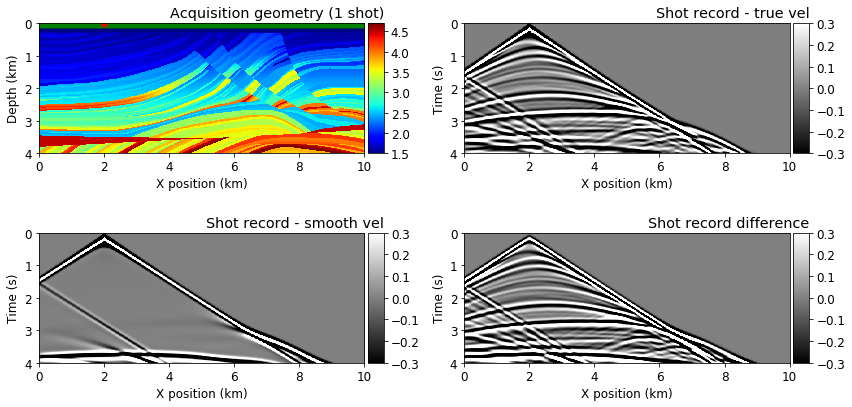

In [5]:
#Pick one source number
isrc = 3
geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                               t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model, geometry, space_order=4)

#Define forward modeling of one source
def modeling_1src(vp_in):    
    # Create symbols to hold the data
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    # Generate modeled data from true model
    _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
    # Compute modeled data and full forward wavefield u0 from smooth model
    _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
    return d_obs, d_syn

#Genearte modeled shot data of both true and smooth velocity models
record, record0 = modeling_1src(model0.vp)

#Plot acquisition geometry and modeled shot data
from plotting import plot_velocity, plot_shotrecord
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.subplot(2,2,1); plot_velocity(model, source=src_loc[isrc-1:isrc,:], receiver=rcv_loc);
plt.title('Acquisition geometry (1 shot)', loc='right')
plt.subplot(2,2,2); plot_shotrecord(record.data, model, t0, tn, vvmax=0.3)
plt.title('Shot record - true vel', loc='right')
plt.subplot(2,2,3); plot_shotrecord(record0.data, model, t0, tn, vvmax=0.3)
plt.title('Shot record - smooth vel', loc='right')
plt.subplot(2,2,4); plot_shotrecord(record0.data - record.data, model, t0, tn, vvmax=0.3)
plt.title('Shot record difference', loc='right')
plt.tight_layout(); plt.show()

## (6) Run 2D FWI with the modeled true shot records and the initial velocity model 
### Define FWI Gradient Operator
To compute a single FWI gradient in our workflow, we again use "solver.forward" to compute the entire forward wavefield u and a similar pre-defined perator to compute the adjoint wavefield v. The gradient operator provided by our solver utility also computes the correlation between the two wavefields u and v, allowing us to derive the FWI gradient. Those three steps that derive the FWI gradient for a particular source are listed below. This procedure is applied to multiple sources and summed to obtain a FWI gradient image of the subsurface. 
* Simulate the forward wavefield u with the background velocity model to obtain the modeled data and save u
* Compute the data residual between the modeled data and true data
* Back-propagate the data residual to derive the wavefield v, and correlate v with the saved wavefield u to compute on the fly the FWI gradient at each time step which will be summed

In [6]:
# Compute the residual between true/observed and modeled/synthetic data
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # Compute the residual via a difference operator for MPI
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual



# Create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]
        # Generate true data "d_obs" from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)
        # Update objective function 
        objective += .5 * norm(residual)**2
        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    return objective, grad



# Define bounding box constraints (clips) on the solution
from sympy import Min, Max
def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
    """
    Apply gradient update in-place to vp with box constraint
    """
    update = vp + alpha * direction
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

### Run 2D FWI interations

In [7]:
import time
fwi_start = time.time()

# Run FWI with gradient descent
fwi_iterations = 300
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = fwi_gradient(model0.vp)
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    #alpha = 0.05 / mmax(direction)
    
    # We add decay to step length "alpha" to stabilize gradient descent
    decay = 1.0 / (1.0 + 0.3*float(i))
    alpha = decay * 0.2 / mmax(direction)

    # Update the velocity model in-place and enforce min/max value clips
    update_with_box(model0.vp, alpha, direction)
    
    # Log the progress of objective function value
    print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


fwi_end = time.time()
print('Total FWI runtime (min):', (fwi_end-fwi_start)/60.0)
print('FWI runtime (min) per iteration:', (fwi_end-fwi_start)/60.0/float(fwi_iterations))

Objective value is   2868867.7   at iteration   1
Objective value is   2438109.7   at iteration   2
Objective value is   2052756.7   at iteration   3
Objective value is   1714066.9   at iteration   4
Objective value is   1472623.5   at iteration   5
Objective value is   1312945.6   at iteration   6
Objective value is   1185783.9   at iteration   7
Objective value is   1070181.9   at iteration   8
Objective value is    956830.1   at iteration   9
Objective value is    854346.7   at iteration  10
Objective value is    752140.8   at iteration  11
Objective value is    675124.4   at iteration  12
Objective value is    614344.1   at iteration  13
Objective value is    565754.1   at iteration  14
Objective value is    523930.9   at iteration  15
Objective value is    554298.4   at iteration  16
Objective value is   1129443.6   at iteration  17
Objective value is    918807.6   at iteration  18
Objective value is    744886.3   at iteration  19
Objective value is    613106.6   at iteration  20


Objective value is     35813.7   at iteration 165
Objective value is     35130.2   at iteration 166
Objective value is     34945.6   at iteration 167
Objective value is     34742.9   at iteration 168
Objective value is     34856.5   at iteration 169
Objective value is     34272.5   at iteration 170
Objective value is     34128.8   at iteration 171
Objective value is     33890.1   at iteration 172
Objective value is     33938.9   at iteration 173
Objective value is     33458.8   at iteration 174
Objective value is     33357.6   at iteration 175
Objective value is     33079.1   at iteration 176
Objective value is     33070.8   at iteration 177
Objective value is     32685.0   at iteration 178
Objective value is     32616.8   at iteration 179
Objective value is     32313.0   at iteration 180
Objective value is     32274.6   at iteration 181
Objective value is     31943.3   at iteration 182
Objective value is     31888.7   at iteration 183
Objective value is     31583.4   at iteration 184


## (7) View the 2D FWI result

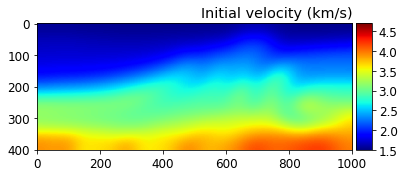

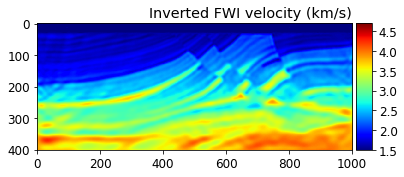

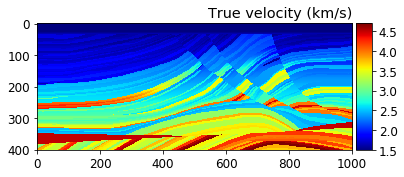

In [8]:
from examples.seismic import plot_image

# Plot initial/smooth velocity model
plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")

# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.5, vmax=4.7, cmap="jet")

# Plot True velocity model
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")

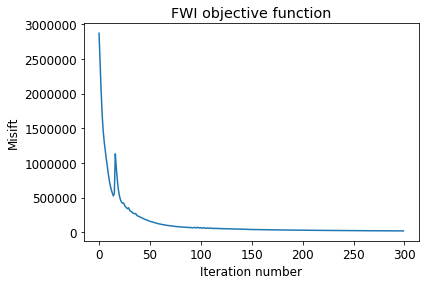

In [9]:
#plot objective function
plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()